import pandas as pd
import os
# Defina o diretório onde seus arquivos CSV estão localizados
diretorio_csv = 'C:/Users/miche/Desktop/CAPSTONE/insper0924'

# Lista todos os arquivos na pasta
arquivos_csv = [arquivo for arquivo in os.listdir(diretorio_csv) if arquivo.lower().endswith('.csv')]

# Inicialize uma lista para armazenar os DataFrames
dataframes = []

# Leia cada arquivo CSV e adicione ao lista de DataFrames
for arquivo in arquivos_csv:
    caminho_completo = os.path.join(diretorio_csv, arquivo)
    df = pd.read_csv(caminho_completo)
    dataframes.append(df)

#load data bases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import prophet
from yahoofinancials import YahooFinancials
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA



In [2]:
#load db preco_anbima and then return the unique values of the column 'correcao'
preco_anbima = pd.read_csv('C:/Users/miche/Desktop/CAPSTONE/insper0924/preco_anbima_di_spread.csv')
print(preco_anbima['correcao'].unique())

['di_spread']


C:\Users\miche\AppData\Local\Temp\ipykernel_12152\3014466254.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  preco_anbima = pd.read_csv('C:/Users/miche/Desktop/CAPSTONE/insper0924/preco_anbima_di_spread.csv')


In [43]:
preco_anbima[['codigo', 'taxaCompra', 'taxaVenda', 'taxaIndicativa']].head()

,codigo,taxaCompra,taxaVenda,taxaIndicativa
0,AGGU12,"1,0463","0,8881","0,9786"
1,ALGA12,"0,9485","0,4428","0,7353"
2,ALGA16,"1,05","0,8","0,9389"
3,ALPA14,"0,9418","0,4228","0,6945"
4,AVIA13,"0,85","0,652","0,79"


### Alterar os tipos de Campos das taxas no df

In [3]:
#tipos dos campos da tabela
preco_anbima.dtypes
#transformar taxaCompra, taxaVenda, taxaIndicativa, indice em float
preco_anbima['taxaCompra'] = preco_anbima['taxaCompra'].str.replace(',', '.').astype(float)
preco_anbima['taxaVenda'] = preco_anbima['taxaVenda'].str.replace(',', '.').astype(float)
preco_anbima['taxaIndicativa'] = preco_anbima['taxaIndicativa'].str.replace(',', '.').astype(float)
preco_anbima['indice'] = preco_anbima['indice'].str.replace(',', '.').astype(float)


In [4]:
#transformar os campos dataReferencia e repacVenc em datetime
preco_anbima['dataReferencia'] = pd.to_datetime(preco_anbima['dataReferencia'], format='%Y-%m-%d', errors='coerce')
preco_anbima['repacVenc'] = pd.to_datetime(preco_anbima['repacVenc'], format='%Y-%m-%d', errors='coerce')

### Criar novo campo Spred_bid_ask

In [5]:
#criar um novo campo chamado 'spread_bid_ask' que é a diferença entre 'taxaCompra' e 'taxaVenda'
preco_anbima['spread_bid_ask'] = preco_anbima['taxaCompra'] - preco_anbima['taxaVenda']

### SPREAD 1 = Spread_bid_ask / taxaIndicativa

In [6]:
#Criar um novo campo chamado spread 1 que e a diferenca entre Spread_bid_ask e taxaIndicativa
preco_anbima['spread'] = preco_anbima['spread_bid_ask'] - preco_anbima['taxaIndicativa']

### Criar novo campo Spread 2 que é a diferença entre o Spread_bid_ask e o indice

In [7]:
#Criar novo campo chamado Spread 2 que e a diferenca entre Spread_bid_ask e indice
preco_anbima['spread_2'] = preco_anbima['spread_bid_ask'] - preco_anbima['indice']

In [8]:
#contar o numero de linhas da tabela
print(preco_anbima.shape[0])

405925


In [20]:
#guardar o novo dataframe em um arquivo csv
preco_anbima.to_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/preco_anbima_di_spread.csv', index=False)




In [2]:
# Ensure the 'dataReferencia' is in datetime format and sort the data for time-series operations
preco_anbima['dataReferencia'] = pd.to_datetime(preco_anbima['dataReferencia'], errors='coerce')
preco_anbima = preco_anbima.sort_values(by=['codigo', 'dataReferencia'])

# Remove missing values from 'taxaIndicativa' and ensure it's numeric
preco_anbima['taxaIndicativa'] = pd.to_numeric(preco_anbima['taxaIndicativa'], errors='coerce')

# Calculate the first difference (stationarization) of 'taxaIndicativa' for each 'codigo'
preco_anbima['taxaIndicativa_diff'] = preco_anbima.groupby('codigo')['taxaIndicativa'].diff()

import ace_tools as tools; tools.display_dataframe_to_user(name="Taxa Indicativa Estacionarizada por Código", dataframe=preco_anbima)

preco_anbima.head()


NameError: name 'preco_anbima' is not defined

In [10]:
#Filtrar pelo codigo ALGA28
preco_anbima_ALGA28 = preco_anbima[preco_anbima['codigo'] == 'ALGA28']

In [52]:
#criar um novo banco de dados com 15 codigos que tenham dados entre 2020 e 2022
preco_anbima_2020_2022 = preco_anbima[(preco_anbima['dataReferencia'] >= '2020-01-01') & (preco_anbima['dataReferencia'] <= '2022-12-31')]
codigos = preco_anbima_2020_2022['codigo'].unique()
codigos = codigos[:15]
preco_anbima_2020_2022_15 = preco_anbima_2020_2022[preco_anbima_2020_2022['codigo'].isin(codigos)]




In [53]:
#Abrir preco_anbima
preco_anbima_ALGA28[['dataReferencia', 'taxaCompra', 'taxaVenda', 'taxaIndicativa', 'spread_bid_ask', 'spread', 'spread_2']].head()

,dataReferencia,taxaCompra,taxaVenda,taxaIndicativa,spread_bid_ask,spread,spread_2
41439,2019-07-15,0.8920,0.7600,0.8527,0.1320,-0.7207,-0.7680
41536,2019-07-16,0.8925,0.7625,0.8449,0.1300,-0.7149,-0.7700
41633,2019-07-17,0.9000,0.7500,0.8440,0.1500,-0.6940,-0.7500
41730,2019-07-18,0.8914,0.7428,0.8352,0.1486,-0.6866,-0.7514
41827,2019-07-19,0.9000,0.7500,0.8328,0.1500,-0.6828,-0.7500


### Para exemplificar vamos utilizar o codigo ALGA28 num periodo de 1 ano

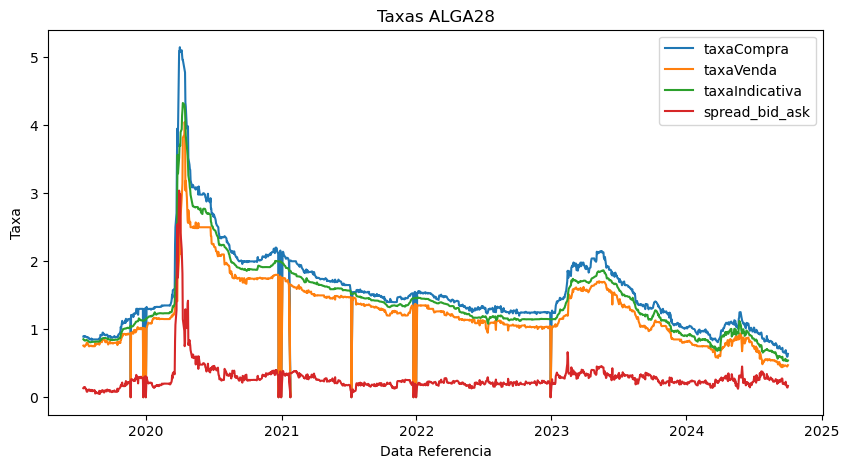

In [54]:
#criar um grafico de linha com o dataframe preco_anbima_ALGA28 usando dataReferencia no eixo x e taxaCompra, taxaVenda, taxaIndicativa, Spread_bid_ask no eixo y, filtrar apenas os dados de dataReferencia entre 2020 e 2022

preco_anbima_ALGA28_2020 = preco_anbima_ALGA28[(preco_anbima_ALGA28['dataReferencia'] >= '2020-01-01') & (preco_anbima_ALGA28['dataReferencia'] <= '2020-12-31')]
plt.figure(figsize=(10,5))
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaCompra'], label='taxaCompra')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaVenda'], label='taxaVenda')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaIndicativa'], label='taxaIndicativa')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['spread_bid_ask'], label='spread_bid_ask')
plt.xlabel('Data Referencia')
plt.ylabel('Taxa')
plt.title('Taxas ALGA28')
plt.legend()
plt.show()

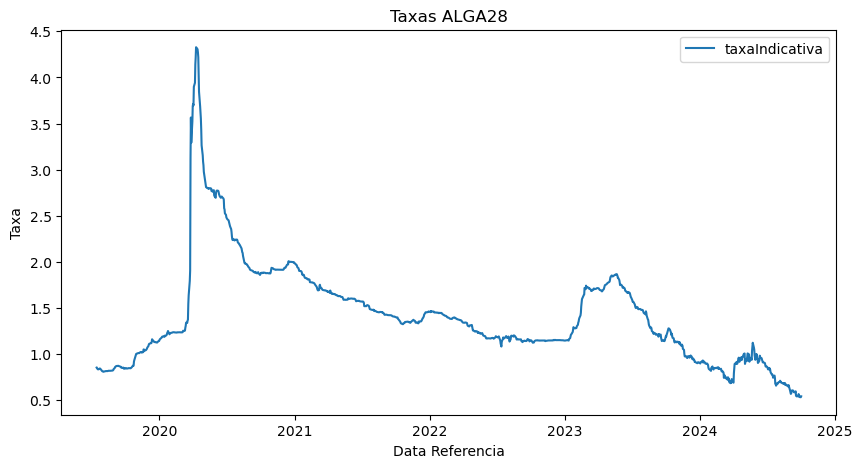

In [55]:
#Total de taxaIndicativa para ALGA28 com todos os dados possiveis
plt.figure(figsize=(10,5))
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaIndicativa'], label='taxaIndicativa')
plt.xlabel('Data Referencia')
plt.ylabel('Taxa')
plt.title('Taxas ALGA28')
plt.legend()
plt.show()

### Rodar uma analise de correlacao entre as variaveis dentro do titulo ALGA28

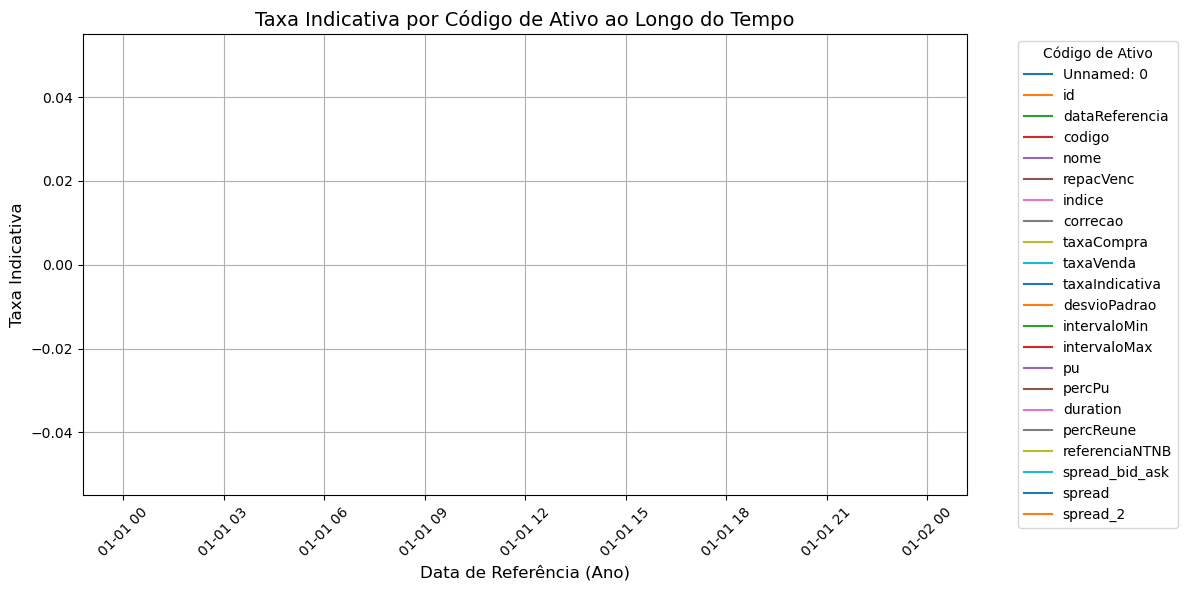

In [56]:
import matplotlib.pyplot as plt

# Plot for each 'codigo'
plt.figure(figsize=(12, 6))
for codigo in preco_anbima_2020_2022_15:
    subset = preco_anbima_2020_2022_15[preco_anbima_2020_2022_15['codigo'] == codigo]
    plt.plot(subset['dataReferencia'], subset['taxaIndicativa'], label=codigo)

# Customizing the plot
plt.xlabel('Data de Referência (Ano)', fontsize=12)
plt.ylabel('Taxa Indicativa', fontsize=12)
plt.title('Taxa Indicativa por Código de Ativo ao Longo do Tempo', fontsize=14)
plt.legend(title='Código de Ativo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


## 1. Decomposição das séries de tempo
### Componentes:

- Tendência
- Sazonalidade
- Ruído


ConversionError: Failed to convert value(s) to axis units: array(['ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28',
       'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28', 'ALGA28'], dtype=object)

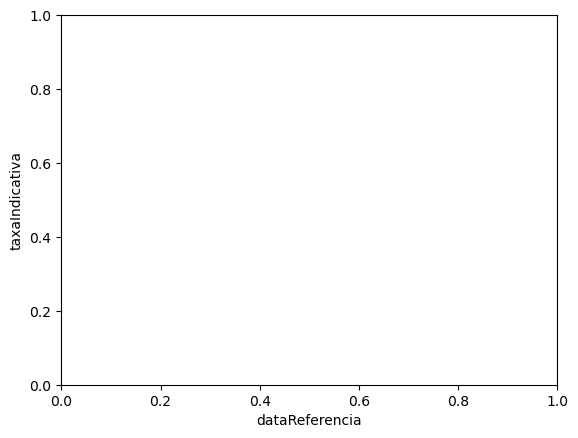

In [64]:
plt.xlabel('dataReferencia')
plt.ylabel('taxaIndicativa')
plt.plot(preco_anbima_ALGA28_2020)

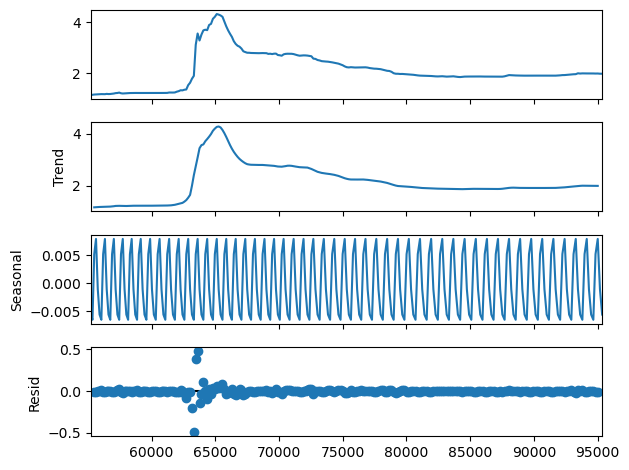

In [65]:
series = preco_anbima_ALGA28_2020[['taxaIndicativa']]
result = seasonal_decompose(series, model='additive',period=5)
result.plot()
plt.rcParams["figure.figsize"] = (9,5)
plt.show()

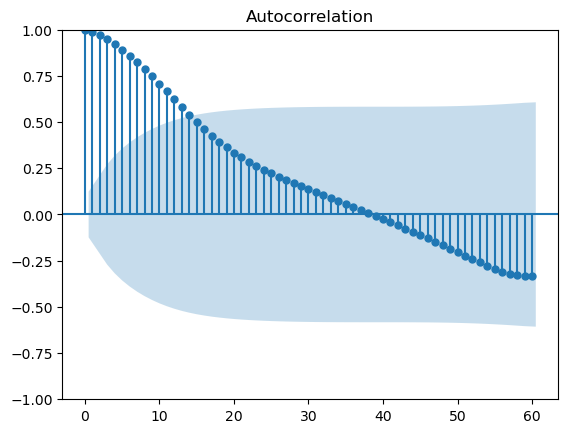

In [63]:
# autocorrelation and partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series, lags=60)
plt.show()